Loading MP3...

Playing 6 silent sections...
Playing silence #1 from 1.24s to 2.78s
Playing silence #2 from 5.64s to 6.48s
Playing silence #3 from 8.67s to 9.00s
Playing silence #4 from 12.09s to 14.66s
Playing silence #5 from 16.55s to 17.02s
Playing silence #6 from 19.79s to 20.55s


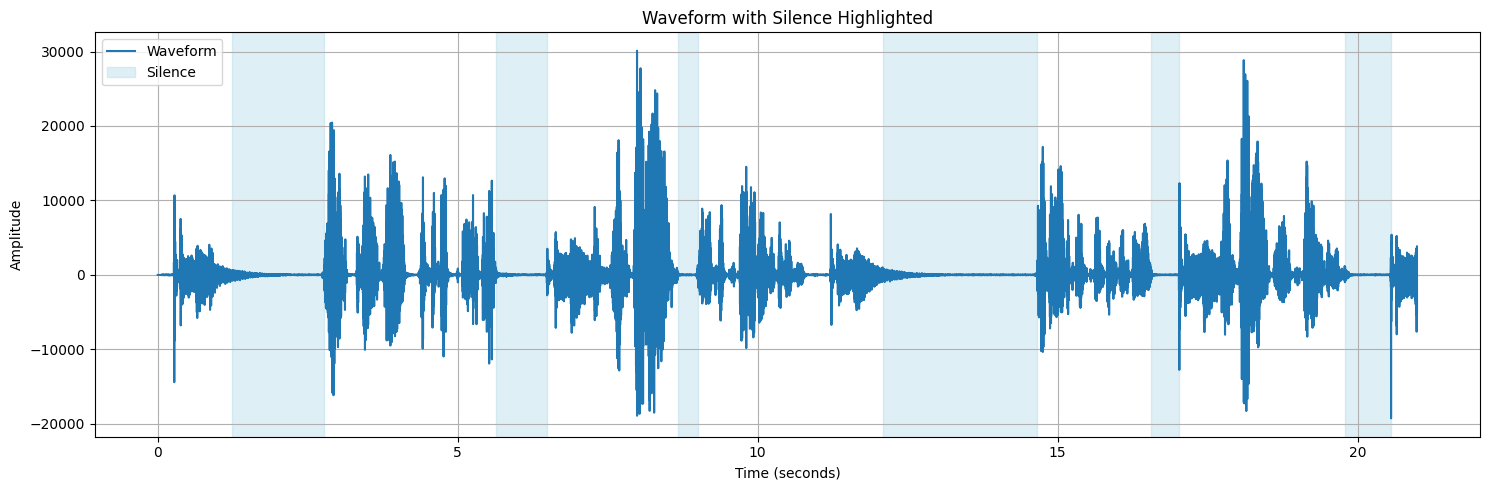

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.playback import play
from scipy.io import wavfile
import tempfile
import os
import time

# === CONFIGURATION ===
mp3_path = "../ufal_emmt/probes/probe02/P21-02-S072-U-C-iu010.mp3"
silence_threshold = 1000  # Amplitude below this is considered "silence"
min_silence_duration_sec = 0.3  # Minimum silence duration to highlight
play_silences = True  # Set to False if you don't want playback

# === LOAD MP3 ===
print("Loading MP3...")
audio = AudioSegment.from_mp3(mp3_path)
audio = audio.set_channels(1)  # Convert to mono

# === EXPORT TO TEMP WAV AND LOAD ===
with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmpfile:
    tmp_path = tmpfile.name
    audio.export(tmp_path, format="wav")

sample_rate, data = wavfile.read(tmp_path)
os.remove(tmp_path)  # Clean up

# === PROCESS WAVEFORM ===
duration_seconds = len(data) / sample_rate
time_axis = np.linspace(0, duration_seconds, num=len(data))

# Normalize if not already float
if data.dtype != np.float32:
    data = data.astype(np.float32)
    data = data / np.max(np.abs(data)) * 32767

# Identify silence
abs_data = np.abs(data)
is_silence = abs_data < silence_threshold

# Find silent regions
silent_regions = []
start_idx = None

for i, val in enumerate(is_silence):
    if val and start_idx is None:
        start_idx = i
    elif not val and start_idx is not None:
        duration = (i - start_idx) / sample_rate
        if duration >= min_silence_duration_sec:
            silent_regions.append((start_idx, i))
        start_idx = None

# Final stretch
if start_idx is not None:
    duration = (len(data) - start_idx) / sample_rate
    if duration >= min_silence_duration_sec:
        silent_regions.append((start_idx, len(data)))

# === PLAYBACK SILENT REGIONS ===
if play_silences:
    print(f"\nPlaying {len(silent_regions)} silent sections...")
    for i, (start, end) in enumerate(silent_regions):
        start_ms = (start / sample_rate) * 1000
        end_ms = (end / sample_rate) * 1000
        segment = audio[start_ms:end_ms]
        print(f"Playing silence #{i+1} from {start_ms/1000:.2f}s to {end_ms/1000:.2f}s")
        play(segment)
        time.sleep(0.5)

# === DOWNSAMPLE FOR PLOTTING ===
step = int(sample_rate * 0.001)
downsampled_time = time_axis[::step]
downsampled_data = data[::step]

# === PLOT ===
plt.figure(figsize=(15, 5))
plt.plot(downsampled_time, downsampled_data, label="Waveform")

# Highlight silent regions
for start, end in silent_regions:
    plt.axvspan(time_axis[start], time_axis[end], color="lightblue", alpha=0.4, label="Silence")

plt.title("Waveform with Silence Highlighted")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()
